# Сбор данных

Первый этап любой работы с данными - это их сбор. Тут возможны варианты в зависимости от ситуации и от глобальной задачи. Три общих подхода к сбору данных на Python:
1. скрейпинг, т.е. извлечение данных с веб-страниц
2. парсинг данных по API
3. использование уже написанных библиотек
4. сбор собственного корпуса вручную

# Упражнение 1. Работа с API

Есть проект "Конструктор ОП" http://op.itmo.ru

## Задание 1.0

Доступ к контенту появляется после регистрации. Можно войти через ИСУ, первый вход = регистрация. Для целей лабораторной работы можно либо создать пользователя, либо воспользоваться тестовым.

В процессе работы нужно будет получить данные по API. Собрать по этим данным датасет (например, можно воспользоваться библиотекой pandas). После провести первичный анализ и сделать визуализации.

 **Получим данные для входа**


**Импортируем необходимые библиотеки**

In [ ]:
import warnings
import json
import os
from time import time

import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

In [ ]:
TOKEN_URL = "https://op.itmo.ru/auth/token/login"
AUTH_DATA = {"username": "analytic", "password": "datatest"}

In [ ]:
response = requests.post(TOKEN_URL, AUTH_DATA).json()

In [ ]:
auth_token = response["auth_token"]

In [ ]:
headers = {"Content-Type": "application/json", "Authorization": "Token " + auth_token}

## Задание 1.1 Получить идентификаторы всех учебных планов, имеющихся в op.itmo.ru

**Получим JSON версию этих данных и сохраним её**

In [ ]:
STUDY_PLAN_URL = "https://op.itmo.ru/api/record/academic_plan/academic_wp_description/all"
CONSECUTIVE_ERRORS_THRESHOLD = 5

In [ ]:
consecutive_errors = 0
for i in range(1, 1000):
    params = {"page": i}
    response_identifier = requests.get(STUDY_PLAN_URL, headers=headers, params=params).json()
    if "detail" in response_identifier:
        consecutive_errors += 1
    else:
        consecutive_errors = 0
        with open(f"../data/study_plans/study_plan_page_{i}.json", "w", encoding="utf-8") as file_out:
            json.dump(response_identifier, file_out, ensure_ascii=False, indent=4)

    if consecutive_errors >= CONSECUTIVE_ERRORS_THRESHOLD:
        break

**Объединим полученные данные в один документ**

In [ ]:
FILE_DIRECTORY = "../data/study_plans/"
filenames = next(os.walk(FILE_DIRECTORY), (None, None, []))[2]
filenames[:5]

['study_plan_page_1.json',
 'study_plan_page_10.json',
 'study_plan_page_11.json',
 'study_plan_page_12.json',
 'study_plan_page_13.json']

In [ ]:
results = []
for filename in filenames:
    with open(FILE_DIRECTORY + filename, encoding="utf-8") as file_in:
        response = json.load(file_in)
        results.extend(response["results"])

with open(FILE_DIRECTORY + "study_plans_all.json", encoding="utf-8", mode="w") as file_out:
    json.dump(results, file_out, indent=4, ensure_ascii=False)

**Загрузим данные и извлечём нужные части**

In [ ]:
with open(FILE_DIRECTORY + "study_plans_all.json", encoding="utf-8") as file_in:
    academic_plan_data = json.load(file_in)

In [ ]:
academic_plan_ids = [item["id"] for item in academic_plan_data]

In [ ]:
display(len(academic_plan_ids))
display(academic_plan_ids[:5])

735

[6796, 6797, 6798, 6799, 6800]

## Итог по шагу 1.1

**Получили 735 идентификатора, что совпадает со значением в API**

## Задание 1.2 По этим планам получить детальное описание

In [ ]:
PLAN_DESCRIPTION_URL = "https://op.itmo.ru/api/academicplan/detail/"
TARGET_YEARS = [2023, 2024]

**Оставим только нужные id**

In [ ]:
academic_plan_target_ids = [item["id"] for item in academic_plan_data if item["academic_plan_in_field_of_study"][0]["year"] in TARGET_YEARS]

In [ ]:
display(len(academic_plan_target_ids))
display(academic_plan_target_ids[:5])

274

[7336, 7334, 7323, 7327, 7324]

**Получили 274 значения, что ≈300, указанным в описании задачи**

In [ ]:
INFO_DIRECTORY = "../data/plans_info/"

In [ ]:
faulty_item_ids = []
for identifier in academic_plan_target_ids:
    try:
        start_time = time()
        response = requests.get(PLAN_DESCRIPTION_URL + str(identifier), headers=headers).json()
        response |= {"request_time": time() - start_time}
    except Exception as e:
        faulty_item_ids.append(identifier)
        print(identifier, str(e))
    else:
        with open(INFO_DIRECTORY + f"plan_{identifier}.json", encoding="utf-8", mode="w") as file_out:
            json.dump(response, file_out, indent=4, ensure_ascii=False)

**Создадим датасет из полученных файлов**

In [ ]:
PLAN_DIRECTORY = "../data/plans_info/"
plan_filenames = next(os.walk(PLAN_DIRECTORY), (None, None, []))[2]
plan_filenames[:5]

['plan_7291.json',
 'plan_7292.json',
 'plan_7293.json',
 'plan_7294.json',
 'plan_7295.json']

In [ ]:
plan_df = pd.DataFrame()
for filename in plan_filenames:
    with open(PLAN_DIRECTORY + filename, encoding="utf-8") as file_in:
        academic_plan_data = json.load(file_in)
        academic_plan_df = pd.json_normalize(academic_plan_data)
        plan_df = pd.concat([plan_df, academic_plan_df])

plan_df.reset_index(level=0, inplace=True, drop=True)

In [ ]:
display(plan_df.shape)
display(plan_df.sample(3))

(274, 20)

,id,educational_profile,number,approval_date,discipline_blocks_in_academic_plan,year,education_form,qualification,author,academic_plan_in_field_of_study,ap_isu_id,on_check,laboriousness,can_edit,can_validate,was_send_to_isu,rating,request_time,excel_generation_errors.wp_err,excel_generation_errors
122,7492,None,None,2023-01-27T16:54:59.845985Z,"[{'id': 30003, 'name': 'Блок 1. Модули (дисцип...",None,None,None,None,"[{'id': 7645, 'year': 2023, 'qualification': '...",22799,verified,120,False,False,True,False,65.608259,[],NaN
46,7338,None,None,2022-11-30T20:04:17.282037Z,"[{'id': 29486, 'name': 'Блок 1. Модули (дисцип...",None,None,None,None,"[{'id': 7402, 'year': 2023, 'qualification': '...",18413,verified,120,False,False,True,False,88.048434,[],NaN
45,7337,None,None,2022-11-30T20:04:17.269300Z,"[{'id': 29482, 'name': 'Блок 1. Модули (дисцип...",None,None,None,None,"[{'id': 7401, 'year': 2023, 'qualification': '...",18409,verified,120,False,False,True,False,78.500234,NaN,NaN


In [ ]:
print(f"Общее время запроса данных составило: {plan_df.request_time.sum() / 60:.3f} минут")

Общее время запроса данных составило: 353.026 минут


## Итог по шагу 1.2

**Получили датасет по 274 планам и общее время запроса данных**

## Задание 1.3 Построить графики и проанализировать

Будем использовать pie-chart диаграммы для визуализации данных, в которых не очень много классов.
На мой взгляд, это наиболее наглядный вид представления данных подобного формата.

**Создадим свой метод для формата данных**

In [ ]:
def count_percent_format(value_count: float) -> str:
    return '{:.2f}%\n({:.0f})'.format(value_count, value_count * plan_df.shape[0] / 100)

**График количества планов по годам набора**

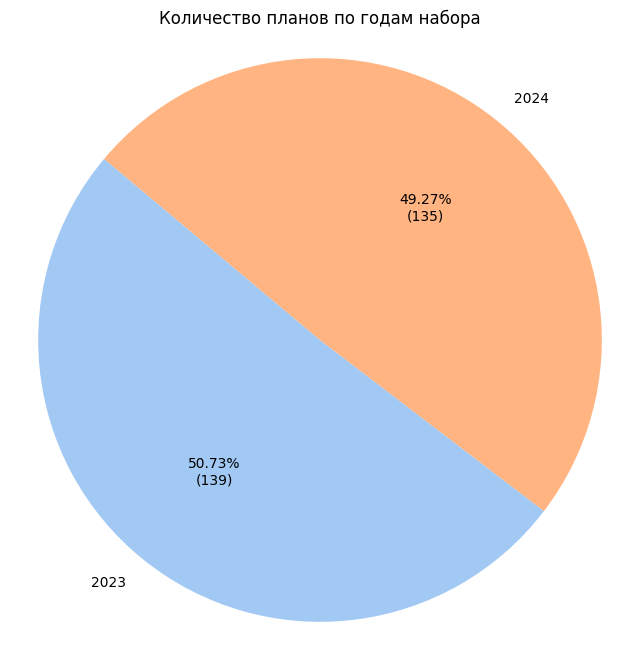

In [ ]:
plan_years = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["year"])
year_counts = plan_years.value_counts()

plt.figure(figsize=(8, 8))
plt.title("Количество планов по годам набора")
sns.set_palette("pastel")
plt.pie(year_counts, labels=year_counts.index, startangle=140, autopct=count_percent_format)
plt.axis("equal")
plt.show()

**Вывод по графику "Количество планов по годам набора"**

Количество учебных планов на 2024 стало на 4 меньше (-2.9%), чем было в 2023 году.
Уменьшение незначительное. Вполне возможно, что на текущий год не все планы ещё были сформированы.

**График количество планов по квалификациям**

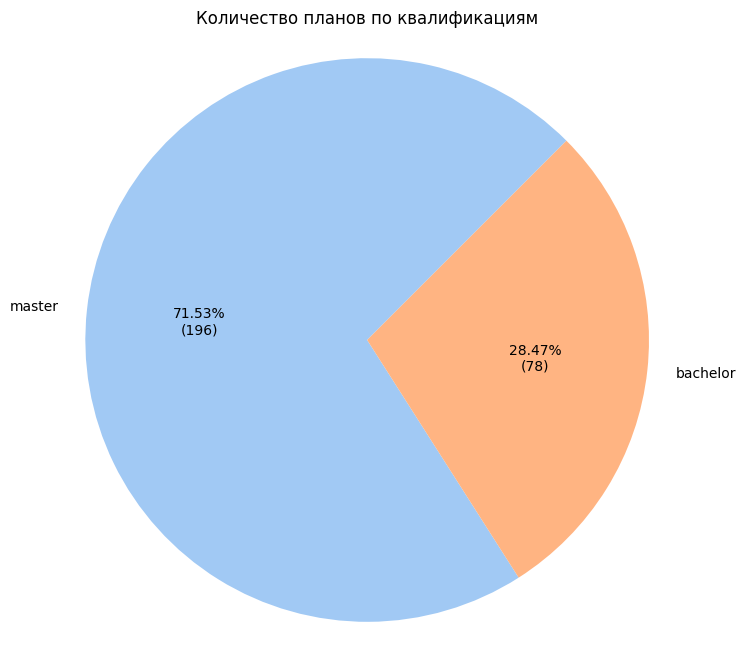

In [ ]:
plan_qualifications = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["qualification"])
qualification_counts = plan_qualifications.value_counts()

plt.figure(figsize=(8, 8))
plt.title("Количество планов по квалификациям")
sns.set_palette("pastel")
plt.pie(qualification_counts, labels=qualification_counts.index, startangle=45, autopct=count_percent_format)
plt.axis("equal")
plt.show()

**Вывод по графику "Количество планов по квалификациям"**

Количество учебных планов для магистратуры заметно отличается от бакалавриата (72% против 28%).
С точки зрения студента это близко к истине, факультеты предоставляют бОльшую гибкость в выборе 2-й ступени высшего образования.

**График количество планов по структурным подразделениям**

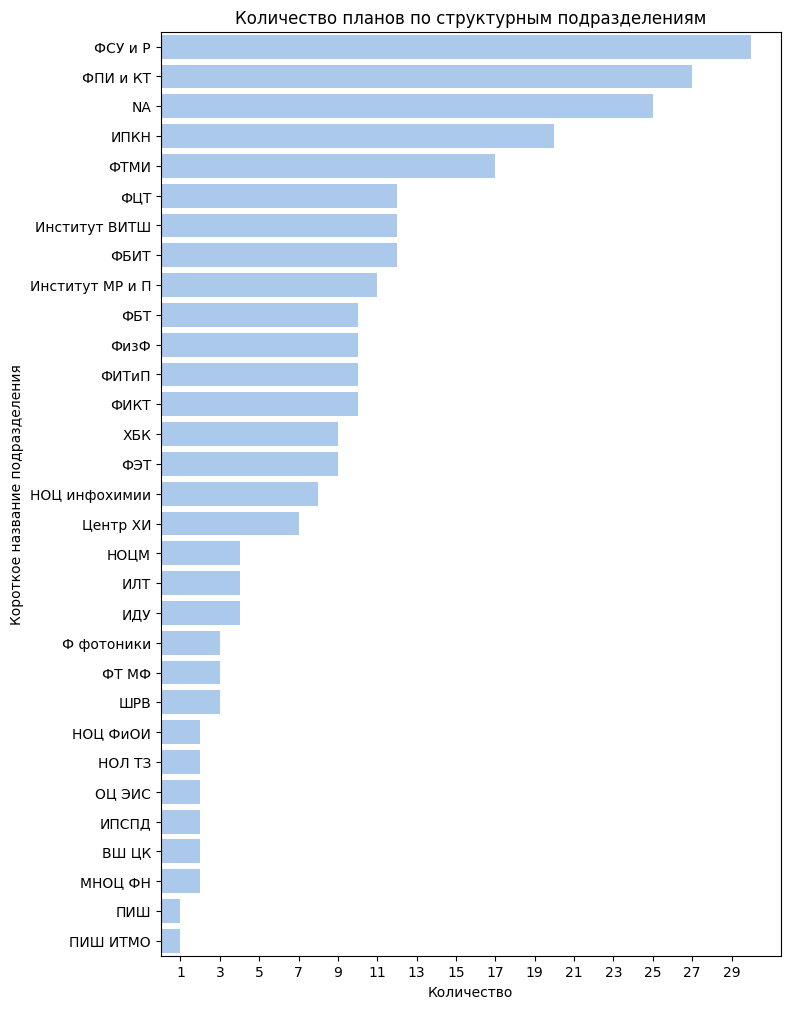

In [ ]:
plan_units = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["structural_unit"])
plan_units = plan_units.apply(lambda x: pd.NA if x is None else x["short_name"])
unit_counts = plan_units.value_counts()
na_count = pd.Series([plan_units.isna().sum()], index=["NA"])
unit_counts = pd.concat([unit_counts, na_count])
unit_counts.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 12))
plt.title("Количество планов по структурным подразделениям")
sns.set_palette("pastel")
sns.barplot(x=unit_counts.values, y=unit_counts.index, orient="h")
plt.xticks(np.arange(1, 30, 2))
plt.xlabel("Количество")
plt.ylabel("Короткое название подразделения")
plt.show()

**Вывод по графику "Количество планов по структурным подразделениям"**

Самое большое количество планов предоставляет "ФСУ и Р" - 30, самое маленькое - "ПИШ" и "ПИШ ИТМО" - по 1 штуке.
Также есть 25 записей (~9%), где поле структурное подразделение не определено.

**График количество планов по количеству редакторов**

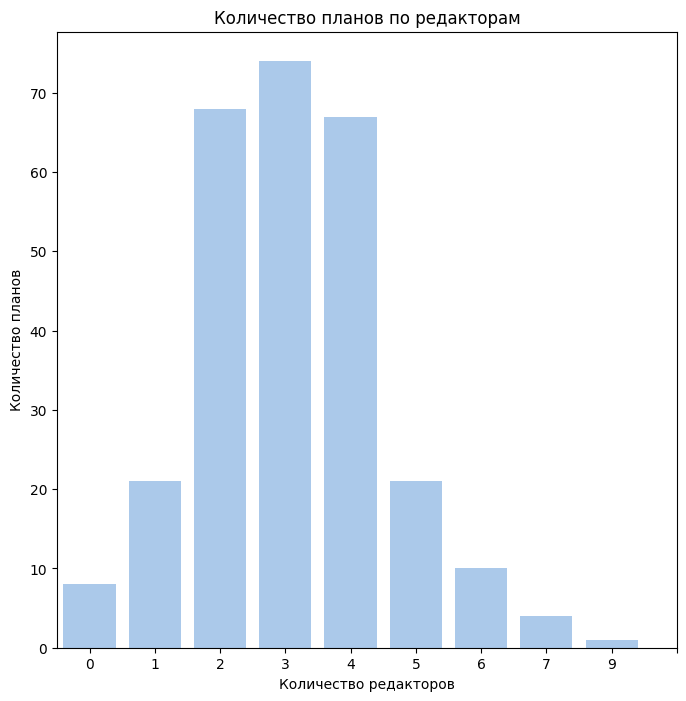

In [ ]:
plan_editors = plan_df["academic_plan_in_field_of_study"].apply(lambda x: len(x[0]["editors"]))
editors_counts = plan_editors.value_counts()

plt.figure(figsize=(8, 8))
plt.title("Количество планов по редакторам")
sns.set_palette("pastel")
sns.barplot(x=editors_counts.index, y=editors_counts.values)
plt.xticks(np.arange(0, 10, 1))
plt.xlabel("Количество редакторов")
plt.ylabel("Количество планов")
plt.show()

**Вывод по графику "Количество планов по редакторам"**

Можно заметить, что самое большое количество планов отредактировано 2-4 людьми.
Также график напоминает нормальное распределение, что звучит логично в данном контексте.

**График количество планов по статусу проверки**

In [ ]:
verification_df = plan_df.copy()
verification_df["year"] = verification_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["year"])

**2023**

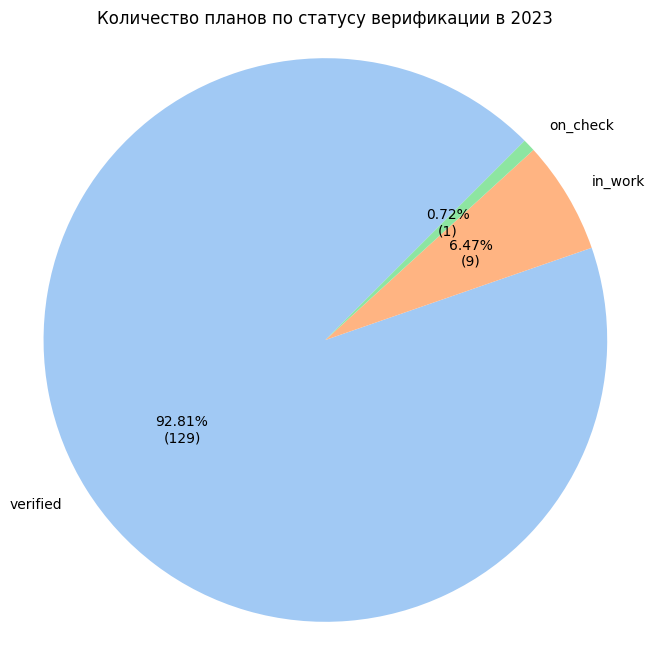

In [ ]:
verification_counts_2023 = verification_df[verification_df["year"] == 2023].on_check.value_counts()

def count_percent_format_2023(value_count: float) -> str:
    return '{:.2f}%\n({:.0f})'.format(value_count, value_count * verification_counts_2023.sum() / 100)


plt.figure(figsize=(8, 8))
plt.title("Количество планов по статусу верификации в 2023")
sns.set_palette("pastel")
plt.pie(verification_counts_2023, labels=verification_counts_2023.index, startangle=45, autopct=count_percent_format_2023)
plt.axis("equal")
plt.show()

**2024**

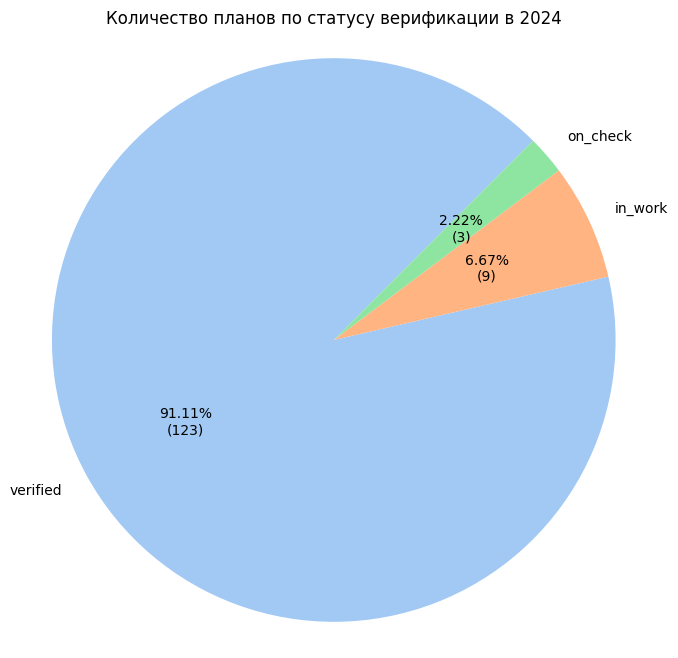

In [ ]:
verification_counts_2024 = verification_df[verification_df["year"] == 2024].on_check.value_counts()

def count_percent_format_2024(value_count: float) -> str:
    return '{:.2f}%\n({:.0f})'.format(value_count, value_count * verification_counts_2024.sum() / 100)


plt.figure(figsize=(8, 8))
plt.title("Количество планов по статусу верификации в 2024")
sns.set_palette("pastel")
plt.pie(verification_counts_2024, labels=verification_counts_2024.index, startangle=45, autopct=count_percent_format_2024)
plt.axis("equal")
plt.show()

**Вывод по графику "Количество планов по статусу верификации"**

БОльшая часть планов проверены, что логично.
Немного удивительным стал факт, что некоторые планы за 2023 до сих пор находятся в работе / на проверке (7.2%).
В целом, распределение по годам весьма схожее.

## Задание 1.4 Анализ

**Найдём проверенные планы**

In [ ]:
faulty_items_df = plan_df.copy()
faulty_items_df["qualification"] = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["qualification"])
faulty_items_df["year"] = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["year"])

plan_structural_units = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["structural_unit"])
plan_structural_unit_titles = plan_structural_units.apply(lambda x: pd.NA if x is None else x["title"])
faulty_items_df["unit_title"] = plan_structural_unit_titles

faulty_items_df["qualification"] = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["qualification"])
faulty_items_df["editors"] = plan_df["academic_plan_in_field_of_study"].apply(lambda x: x[0]["editors"])
faulty_items_df = faulty_items_df[faulty_items_df.on_check == "verified"]
faulty_items_df.shape

(252, 22)

**Проверим, которые имеют некорректную трудоёмкость**

In [ ]:
faulty_items_bachelor_df = faulty_items_df.query("qualification == 'bachelor' & laboriousness != 240")
display(faulty_items_bachelor_df.shape)

faulty_items_master_df = faulty_items_df.query("qualification == 'master' & laboriousness != 120")
display(faulty_items_master_df.shape)

(6, 22)

(5, 22)

**Бакалавриат**

In [ ]:
faulty_items_bachelor_df[["year", "id", "ap_isu_id", "unit_title", "editors"]]

,year,id,ap_isu_id,unit_title,editors
3,2023,7294,18340,факультет экотехнологий,"[{'id': 110, 'username': '241191', 'first_name..."
6,2023,7297,18343,факультет инфокоммуникационных технологий,"[{'id': 253, 'username': '105760', 'first_name..."
24,2023,7315,18361,научно-образовательный центр инфохимии,"[{'id': 936, 'username': '337555', 'first_name..."
25,2023,7316,18362,факультет биотехнологий,"[{'id': 2044, 'username': '275087', 'first_nam..."
30,2023,7321,18366,институт международного развития и партнерства,"[{'id': 466, 'username': '103466', 'first_name..."
130,2023,7500,28097,факультет инфокоммуникационных технологий,"[{'id': 51, 'username': '134011', 'first_name'..."


**Магистратура**

In [ ]:
faulty_items_master_df[["year", "id", "ap_isu_id", "unit_title", "editors"]]

,year,id,ap_isu_id,unit_title,editors
91,2023,7385,18414,факультет экотехнологий,"[{'id': 100, 'username': '165829', 'first_name..."
92,2023,7386,18416,факультет экотехнологий,"[{'id': 100, 'username': '165829', 'first_name..."
96,2023,7390,18405,факультет биотехнологий,"[{'id': 2044, 'username': '275087', 'first_nam..."
107,2023,7401,18397,институт международного развития и партнерства,"[{'id': 2024, 'username': '364389', 'first_nam..."
134,2023,7504,None,<NA>,[]
